# Assignment 5: Classification

## Q1 Classification (5 points)

This assignment needs train.csv and test.csv. train.csv is for training and test.csv is for test. Both of them have samples in the following format:

|label | text |
|------|------|
|2|  I must admit that I'm addicted to "Version 2.0...|
|1|  I think it's such a shame that an enormous tal...|
|2|  The Sunsout No Room at The Inn Puzzle has oddl...|
|...|...|

Write a function **classify** to conduct a classification experiement as follows: (overall 1 point)
1. Take the training and testing file names (strings) as inputs, e.g. classify(training_file, testing_file). 
2. Classify text samples in the training file using **Multinomial Naive Bayes model** as follows: 
   - a. First apply grid search with **5-fold cross validation** to find the best values for parameters **min_df**, **stop_words**, and **alpha** of Naive Bayes model that are used the modeling pipeline. Use f1-macro as the scoring metric to select the best parameter values. Potential values for these parameters are: (2 point)
      * min_df' : [1,2,3]
      * stop_words' : [None,"english"]
      * alpha: [0.5,1,2] 
   - b. Using the best parameter values, train a Multinomial Naive Bayes classifier with all samples in the training file (1 point)
3. Test the classifier created in Step 2.b using the test file. Report the testing performance as: 
   - Precision, recall, and f1-score of each label (0.5 point)
   - Treat label 2 as the positive class, plot precision-recall curve and ROC curve, and calculate AUC. (0.5 point)
4. Your function "classify" has no return. However, when this function is called, the best parameter values from grid search is printed and the testing performance from Step 3 is printed. 

## Q2. How many samples are enough? Show the impact of sample size on classifier performance (5 points)

This question will use train_large.csv dataset.

Write a function "impact_of_sample_size" as follows:
- Take the full file name path string for a dataset inputs, e.g. impact_of_sample_size(dataset_file). 
- Starting with 800 samples from the dataset, **in each round you build a classifier with 400 more samples**. i.e. in round 1, you use samples from 0:800, and in round 2, you use samples from 0:1200, …, until you use all samples. (1 point)
- In each round, do the following:
    1. create tf-idf matrix using TfidfVectorizer with **stop words removed** (0.5 point)
    2. train a classifier using **multinomial Naive Bayes** model with 5-fold cross validation (0.5 point)
    3. train a classifier using **linear support vector machine** model with 5-fold cross validation (0.5 point)
    4. for each classifier, collect the following average metrics across 5 folds: (0.5 point)
        - average F1 macro
        - average AUC: treat label 2 as the positive class, and set "roc_auc" along with "f1_macro" as metrics
- Plot a line chart (two lines, one for each classifier) show **the relationship between sample size and F1-score**. Similarly, plot another line chart to show **the relationship between sample size and AUC**  (1 point)
- Write your analysis in a **separate pdf file (not in code)** on the following: (1 point)
  - How does the sample size affect each classifier’s performance? 
  - How many samples do you think would be needed for each model for good performance? 
  - How is performance of SVM classifier compared with Naïve Bayes classifier, as the sample size increases? 
- There is no return for this function, but the charts should be plotted.

## Q3 (Bonus): Predict duplicate questions by classification (3 points)

You have tired to predict duplicate questions using the dataset 'quora_duplicate_question_500.csv' by similarity. This time, try to use a classification model to predict if a question pair $(q_1, q_2)$ are indeed duplicate. 

|q1 | q2 |is_duplicate|
|------|------|
|How do you take a screenshot on a Mac laptop?|  How do I take a screenshot on my MacBook Pro? ...|   1 |
|Is the US election rigged?|  Was the US election rigged?|   1 |
|How scary is it to drive on the road to Hana g...|  Do I need a four-wheel-drive car to drive all ...	|  0  |
|...|...| ...|

In your Assignment 4, with cosine similarity, the AUC is about 74%. In this assignment, define a function **classify_duplicate** to achieve the following:
- Take the full name of the dataset file (i.e.'quora_duplicate_question_500.csv') as the input
- **do feature engineering to extract a number of good features**. A few possible options for feature engineering can be:
    - Unigram, bigram, trigram etc.
    - Keep or remove stop words
    - Different metrics, e.g. cosine similarity, BM25 score (https://en.wikipedia.org/wiki/Okapi_BM25), etc.
- build a ** classification model (e.g. SVM) using these features to predict if a pair questions are duplicate or not**. (1 point)
- Your target is to **improve the average AUC of the positive class through 5-fold cross validation by at least 1%, reaching 75% or higher**. (2 points, if the AUC is 75%; otherwise 0)
- return the average AUC

In [231]:
import pandas as pd
import nltk

from sklearn.model_selection import cross_validate
from sklearn.metrics import precision_recall_fscore_support
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import svm
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc,precision_recall_curve
from sklearn.model_selection import train_test_split
from sklearn import metrics
import numpy as np
from matplotlib import pyplot as plt
import spacy
import scipy 

In [238]:
# Q1

def classify(train_file, test_file):
             
    df=pd.read_csv(train_file, header=0)
    df_test=pd.read_csv(test_file, header=0)
    
    # search for best parameters
    text_clf = Pipeline([('tfidf', TfidfVectorizer()),
                        ('clf', MultinomialNB())
                   ])

    parameters = {'tfidf__min_df':[1,2,5],
              'tfidf__stop_words':[None,"english"],
              'clf__alpha': [0.5,1,2,5]  }

    metric =  "f1_macro"

    gs_clf = GridSearchCV(text_clf, param_grid=parameters, scoring=metric, cv=5)

    gs_clf = gs_clf.fit(df["text"], df["label"])

    for param_name in sorted(parameters.keys()):
        print("%s: %r" % (param_name, gs_clf.best_params_[param_name]))

    print("best f1_macro:", gs_clf.best_score_)
    
    # use best parameters to train models
    
    tfidf_vect = TfidfVectorizer(stop_words=gs_clf.best_params_['tfidf__stop_words'],\
                                min_df=gs_clf.best_params_['tfidf__min_df']) 
    
    dtm= tfidf_vect.fit_transform(df["text"])

    clf = MultinomialNB(alpha=gs_clf.best_params_['clf__alpha']).fit(dtm, df["label"])
    
    # test model
    dtm_test=tfidf_vect.transform(df_test["text"])
    predicted=clf.predict(dtm_test)

    labels=sorted(df["label"].unique())

    print(classification_report(df_test["label"], predicted, labels=labels))
    
    # AUC
    predicted=clf.predict_proba(dtm_test)
    fpr, tpr, thresholds = roc_curve(df_test["label"], predicted[:,1], pos_label=2)

    print(auc(fpr, tpr))
    
    plt.figure();
    plt.plot(fpr, tpr, color='darkorange', lw=2);
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--');
    plt.xlim([0.0, 1.0]);
    plt.ylim([0.0, 1.05]);
    plt.xlabel('False Positive Rate');
    plt.ylabel('True Positive Rate');
    plt.title('AUC of Naive Bayes Model');
    plt.show();
    
    # precision-recall curve
    precision, recall, thresholds = precision_recall_curve(df_test["label"], predicted[:,1], pos_label=2)

    plt.figure();
    plt.plot(recall, precision, color='darkorange', lw=2);
    plt.xlim([0.0, 1.0]);
    plt.ylim([0.0, 1.05]);
    plt.xlabel('Recall');
    plt.ylabel('Precision');
    plt.title('Precision_Recall_Curve of Naive Bayes Model');
    plt.show();

In [239]:
# Q2

def impact_of_sample_size(train_file):
    
    df=pd.read_csv(train_file, header=0)
    
    results=[]
    tfidf_vect = TfidfVectorizer(stop_words="english") 
    dtm= tfidf_vect.fit_transform(df["text"])
    
    metrics = [ "f1_macro", "roc_auc"]
    
    clf1 = svm.LinearSVC()
    clf2 = MultinomialNB()


    labels=sorted(df["label"].unique())

    s=800

    while s<=len(df):    
        
        # SVM
        
        cv = cross_validate(clf1, dtm[0:s], df["label"].iloc[0:s],\
                    scoring=metrics, cv=5)
        f1 = np.mean(np.array(cv['test_f1_macro']))
        auc1 = np.mean(np.array(cv['test_roc_auc']))
        
        cv = cross_validate(clf2, dtm[0:s], df["label"].iloc[0:s],\
                    scoring=metrics, cv=5)
        f2 = np.mean(np.array(cv['test_f1_macro']))
        auc2 = np.mean(np.array(cv['test_roc_auc']))
        
        results.append((s, f1, f2, auc1, auc2))
        s+=400

    results=pd.DataFrame(results, columns=["size","f1_svm","f1_nb", "auc_svm", "auc_nb"])

    results=results.set_index("size")   
    
    results[["f1_svm","f1_nb"]].plot(kind="line")
    plt.show()
    
    results[["auc_svm","auc_nb"]].plot(kind="line")
    plt.show()


In [240]:
#Q3
def classify_duplicate(filename):
    data=pd.read_csv("../../dataset/quora_duplicate_question_500.csv",header=0)
    
    tfidf_vect = TfidfVectorizer() 
    dtm= tfidf_vect.fit_transform(data["q1"].values.tolist()+data["q2"].values.tolist())
    unigram_sim = np.sum(dtm[0:500].multiply(dtm[500:]), axis=1)
    
    tfidf_vect = TfidfVectorizer(ngram_range=(2,3)) 
    dtm = tfidf_vect.fit_transform(data["q1"].values.tolist()+data["q2"].values.tolist())
    ngram_sim = np.sum(dtm[0:500].multiply(dtm[500:]), axis=1)
    
    metrics = ["roc_auc"]
    clf = svm.LinearSVC()

    cv = cross_validate(clf, np.hstack([unigram_sim, ngram_sim]), \
                        data["is_duplicate"], scoring=metrics, cv=5)
    return np.mean(np.array(cv['test_roc_auc']))

clf__alpha: 2
tfidf__min_df: 1
tfidf__stop_words: None
best f1_macro: 0.7134380001639543
              precision    recall  f1-score   support

           1       0.74      0.76      0.75        99
           2       0.76      0.74      0.75       102

   micro avg       0.75      0.75      0.75       201
   macro avg       0.75      0.75      0.75       201
weighted avg       0.75      0.75      0.75       201

0.835016835016835


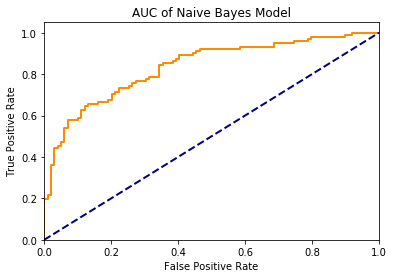

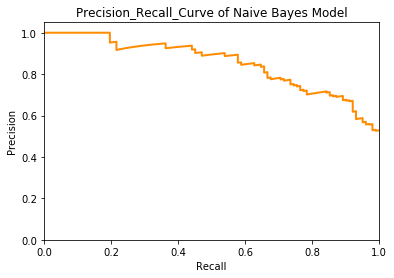

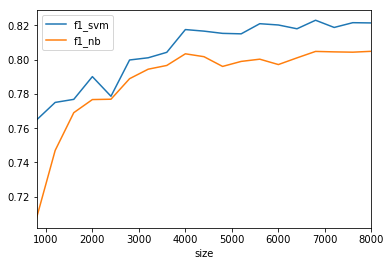

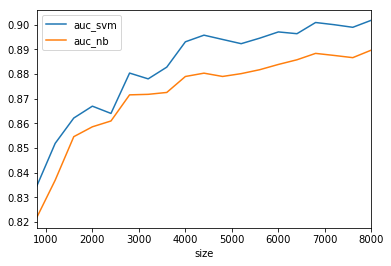

Q3:  0.760092681967682


In [242]:
if __name__ == "__main__":  
    # Question 1
    # Test Q1
    classify("../../dataset/amazon_review_500.csv",\
         "../../dataset/sent_test.csv")
    
    # Test Q2
    impact_of_sample_size("../../dataset/sent_train_large.csv")
    
    # Test Q3
    result = classify_duplicate("../../dataset/quora_duplicate_question_500.csv")
    print("Q3: ", result)